# **4. DCGAN Tutorial**

# What is a GAN?

GAN은 학습 데이터들의 분포를 학습한뒤, 동일한 분포를 갖는 새로운 데이터를 생성하도록 딥러닝 모델을 학습시키는 프레임워크임

GAN은 생성자(Generator)와 구분자(Discriminator)라는 두개의 서로 다른(distinct) 모델로 구성됨

생성자는 가짜 이미지를 만들고 구분자는 이미지를 보고 이것이 실제 학습 데이터에서 가져온 것인지 아니면 생성자에 의해 만들어진 이미지인지 판별하는 역할

이런식으로 서로를 속이고 판별하면서 판별자가 50%의 신뢰도로 생성자의 출력이 진짜인지 가짜인지 판별할 수 있을 때 균형 상태(equilbrium)에 도달

구분자의 표기들

x : 이미지로 표현되는 데이터

D(x) : 구분자의 신경망, 실제 학습 데이터에서 가져온 x를 통과시켜 확률 값(scalar)을 결과로 출력 여기서는 이미지 데이터를 다루므로 D(x)의 입력으로는 3 x 64 x 64 크기의 CHW 이미지

직관적으로 D(x)는 x가 학습 데이터에서 가져왔을 때 출력이 크고 생성자가 만들어낸 x일 때는 작을 것임

생성자의 표기들

z : 정규분포에서 뽑은 laten space vector(잠재공간 벡터) = 정규분포에서 n개의 원소를 추출한 것과 같음

G(z) : z 벡터를 원하는 데이터 차원으로 대응시키는 신경망

G의 목적은 P_data 에서 얻을 수 있는 학습 데이터들의 분포를 추정하며 모사한 P_g의 분포를 이용해 가짜 데이터를 만드는

D(G(z)) : G가 출력한 결과물이 실제 이미지 여부를 나타내는 0 ~ 1 사이의 확률값(scalar)

In [ ]:
# !unzip -qq '/content/drive/MyDrive/학부연구생/Pytorch - Image and Video/celeba/img_align_celeba.zip' -d '/content/drive/MyDrive/학부연구생/Pytorch - Image and Video/celeba'

# What is a DCGAN?

DCGAN은 위에서 기술한 GAN에서 직접적으로 파생된 모델 생성자와 구분자에서 합성곱 신경망과 전치 합성곱 신경망(convolution-transpose)을 사용했다는 것이 차이점임

전치 합성곱 계층은 잠재공간 벡터로 하여금 이미지와 같은 차원을 갖도록 변환시켜주는 역할을 함 (전치 합성곱 신경망은 합성곱 신경망의 반대적인 개념이라 이해하면 쉬움 입력된 작은 CHW 데이터를 가중치들을 이용해 더 큰 CHW로 업샘플링해주는 계층)

In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 실행결과 동일성을 위한 시드값 고정
manualSeed = 999

print('Random Seed: ',manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # 결과 재현을 위해 필요

Random Seed:  999


In [ ]:
dataroot = '/content/drive/MyDrive/학부연구생/Pytorch - Image and Video/celeba'

# dataloader 에서 데이터를 불러올 때 사용할 워커 쓰레드의 수
workers = 2

# 학습에 사용할 배치 크기
batch_size = 128

# 학습에 사용할 이미지 크기 64 x 64
image_size = 64

# 입력 이미지의 색상의 채널 수 RGB 라서 3
nc = 3

# 잠재공간 벡터의 원소들의 수
nz = 100

# 생성자 (G)를 통과할 때 만들어질 특징 데이터의 채널 수
ngf = 64

# 구분자 (D)를 통과할 때 만들어질 특징 데이터의 채널 수
ndf = 64

# 학습시킬 에폭 수
num_epochs = 5

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저에서 사용할 beta1 하이퍼파라미터 값
beta1 = 0.5

# 사용가능한 gpu 개수
ngpu = 1

# Data

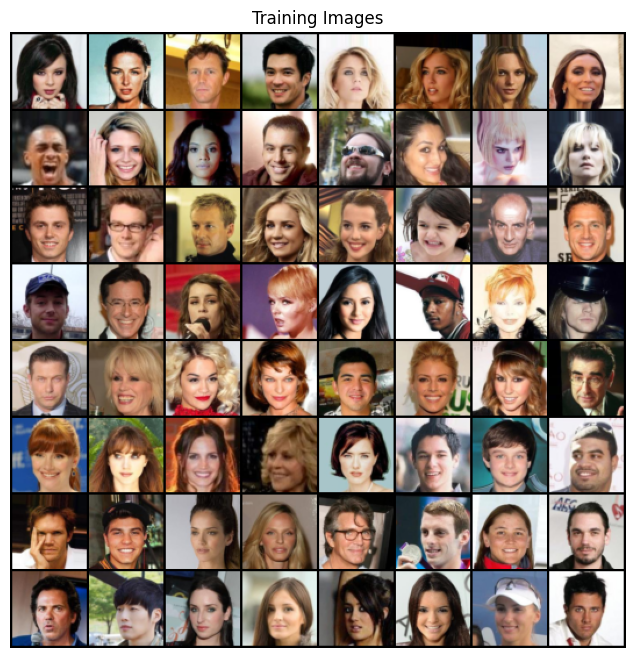

In [ ]:
from torch.utils.data import Subset
# ImageFolder 클래스가 데이터셋의 최상위 폴더에 서브폴더를 요구해서
# celeba 폴더 안에 다시 폴더를 둔거임
dataset = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),]))

small_dataset = Subset(dataset, list(range(20000)))
dataloader = torch.utils.data.DataLoader(small_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 몇가지 이미지만 확인
real_batch = next(iter(dataloader))
plt.figure(figsize = (8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Implementation

# weight Initialization

논문에선 평균이 0이고 분산이 0.02인 정규분포를 사용해 구분자와 생성자 모두 무작위 초기화를 하는 것이 좋다고 함

weights_init() 함수는 매개변수로 모델을 입력받아 모든 합성곱 계층, 전치 합성곱 계층, 배치 정규화 계층을 위에서 말한 조건대로 가중치들을 다시 초기화 시킴

이 함수를 그리고 모델이 만들지자마자 적용을 시킴

In [ ]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

# Generator

생성자 G는 잠재 공간 벡터 z를 데이터 공간으로 변환시키도록 설계됨

우리에게 데이터는 이미지이기 때문에 z를 데이터 공간으로 변환한다는 뜻은 학습이미지와 같은 사이즈를 가진 RGB 이미지를 생성하는 것과 같음

실제 모델에서는 stride 2를 가진 전치 합성곱 계층들을 이어서 구성하는데 각 전치 합성곱 계층 하나당 2차원 배치 정규화 계층과 relu 한수를 한쌍으로 묶어서 사용

생성자의 마지막 출력 계층에서는 데이터를 tanh 함수에 통과시키는데 이는 출력 값을 [-1, 1] 사이의 범위로 조정하기 위함

이때 배치 정규화 계층을 주목해야되는데 이 계층이 경사하강법의 흐름에 중요한 영향을 미친다고 함

처음 정의한 값들 nz, ngf, nc 가 생성자 모델 아키텍쳐에 어떻게 영향을 끼치는지 주목해야됨

- nz 는 z 입력 벡터의 길이

- ngf는 생성자를 통과하는 특징 데이터의 크기

- nc는 출력 이미지의 채널 개수 (RGB 니까 3)

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # 입력데이터 벡터 z가 처음 통과하는 전치 합성곱 계층
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),

        # 위의 계층을 통과한 데이터의 크기 = (ngf * 8) x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),

        # 위의 계층을 통과한 데이터의 크기 = (ngf * 4) x 8 x 8
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),

        # 위의 계층을 통과한 데이터의 크기 = (ngf * 2) x 16 x 16
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        # 위의 계층을 통과한 데이터의 크기 = ngf x 32 x 32
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # 위의 계층을 통과한 데이터의 크기 = nc x 64 x 64
    )

  def forward(self, input):
    return self.main(input)

In [ ]:
# 생성자 만들기
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

# weight_init 함수를 통해 모든 가중치 초기화
netG.apply(weights_init)

# 모델 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

구분자 D 는 입력이미지가 진짜인지 가짜인지 판별하는 전통적인 이진 분류 신경망

D 는 3 x 64 x 64 이미지를 입력받아 Conv2d, BatchNorm2d, LeakyReLU 계층을 통과시켜 데이터 가공하고 마지막에 Sigmoid로 0~1로 확률값 조정

논문에선 보폭이 있는 합성곱 계층을 사용하는 것이 신경망 내에서 스스로 pooling 함수를 학습하기 때문에 데이터를 처리하는 과정에서 직접적으로 풀링계층을 사용하는것보다 유리



In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # 입력 데이터의 크기 = nc x 64 x 64
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        # 위의 계층을 통과한 데이터의 크기 = ndf x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2, inplace=True),

        # 위의 계층을 통과한 데이터의 크기 = (ndf * 2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),

        # 위의 계층을 통과한 데이터의 크기 = (ndf * 4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),

        # # 위의 계층을 통과한 데이터의 크기 = (ndf * 2) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.main(input)

In [ ]:
# 구분자 만들기
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

# weight_init 함수를 통해 모든 가중치 초기화
netD.apply(weights_init)

# 모델 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Loss Functions and Optimizers

In [ ]:
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참 / 거짓 라벨
real_label = 1.
fake_label = 0.

# G 와 D 에서 구분되는 Adam 옵티마이저 생
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training

GAN을 학습시키는 건 관례적인 기술들의 집합이라 잘못된 하이퍼파라미터 설정은 모델의 학습을 망가뜨릴 수 있음 그래서 논문에 서술된 algorithm 1을 기반으로 몇가지 괜찮은 테크닉을 더할거임

Part 1 - 구분자의 학습

구분자의 목적은 주어진 입력값이 진짜인가 가짜인가 판별임, 구분자는 gradient를 상승(ascending) 시키며 훈련

log(D(x)) + log(1-D(G(z)))를 최대화 시키는 것

1. 진짜 데이터로만 이루어진 배치를 만들어 구분자 D 에 통과 시킴 그 출력값으로 log(D(x))의 손실값을 계산하고 역전파 과정에서의 변화도들을 계산

2. 오로지 가짜 데이터로만 이루어진 배치를 만들어 구분자 D 에 통과시킴 그 출력값으로 log(1-D(G(z)))의 손실값을 계산해 역전파 변화도를 구하면 됨

이때 두가지 과정에서의 나오는 변화도들은 accumulate 해야됨 그리고 나서 optimizer를 사용하면 됨

Part 2 - 생성자의 학습

논문에서 생성자는 log(1-D(G(z))) 를 최소화 하는 방향으로 학습 근데 이건충분히 변하지 않아서 log(D(G(z)))를 최대화 하는 방식으로 바꿔서 하겠음

Part 1 에서 한대로 구분자를 이용해 생성자의 출력값을 판별해주고 진짜 라벨값을 이용해 G의 손실값을 구해줌, 구해진 손실값으로 변화도를 구하고 최종적으로는 옵티마이저로 생성자 G의 가중치를 업데이트 시켜주면됨

언뜻 보면 생성자가 만들어낸 가짜 이미지에 진짜 라벨을 사용하는것이 직관적으로 위배가 될테지만 이렇게 라벨을 바꿔서 log(x) 라는 BCELoss의 일부분을 사용할 수 있게함

밑에 코드에서 통계적인 수치들을 출력할거임

Loss_D : 진짜 데이터와 가짜 데이터들 모두에서 구해진 손실값 log(D(x)) + log(1-D(G(z)))

Loss_G : 생성자의 손실값 log(D(G(z)))

D(x) : 구분자가 데이터를 판별한 확률값으로 처음엔 1에 가까운 값이다가 G가 학습할수록 0.5값에 수렴하게 됨

D(G(z)) : 가짜데이터들에 대한 구분자의 출력값으로 처음엔 0에 가깝다가 G가 학습할 수록 0.5값에 수렴하게 됨

In [ ]:
# 학습상태 체크를 위한 손실값 저장
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
  for i, data in enumerate(dataloader, 0):
    ################
    # (1) D 신경망을 업데이트 함 : log(D(x)) + log(1 - D(G(z)))를 최대화 함
    ################
    # 우선 진짜 데이터들로 학습
    netD.zero_grad()

    # 배치들의 사이즈나 사용할 디바이스에 맞게 조정
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

    # 진짜 데이터들로 이루어진 배치를 D에 통과시킴
    output = netD(real_cpu).view(-1)

    # 손실값 계산 -> gradient 계산
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    # 가짜 데이터들로 학습
    # 생성자에 사용할 잠재공간 벡터 생성
    noise = torch.randn(b_size, nz, 1, 1, device=device)

    # G를 이용해 가짜 이미지 생성
    fake = netG(noise)
    label.fill_(fake_label)

    # D를 이용해 데이터의 진위 판별
    output = netD(fake.detach()).view(-1)

    # D의 손실값 계산 -> gradient 계산 후 앞서 구한 gradient에 accumulate
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    # 가짜와 진짜 이미지 모두에서 구한 손실값들을 더하는데
    # errD 는 역전파에서는 사용안되고 이후 학습 상태 reporting 할때 사용
    errD = errD_real + errD_fake
    # D 없데이트
    optimizerD.step()

    ################
    # (2) G 신경망을 업데이트 함 : log(D(G(z)))를 최대화 함
    ################
    netG.zero_grad()
    label.fill_(real_label)

    # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할거\
    # 우리는 방금 D를 업데이트 했으니까 D에 다시 가짜 데이터를 통과시켜야됨
    # 이때 G는 업데이트 되지 않지만 D가 업데이트 되었어서 앞선 손실값이 다른 값이 나옴
    output = netD(fake).view(-1)

    # G의 손실값 계산 -> gradient 계산 -> optimizer
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

    # 훈련 상태 출력
    if i % 50 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
      % (epoch, num_epochs, i, len(dataloader),
         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # 손실갑 저장
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # fixed_noise 를 통과시킨 G의 출력값 저장
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1

Starting Training Loop...
[0/5][0/157]	Loss_D: 1.7566	Loss_G: 4.8288	D(x): 0.5452	D(G(z)): 0.5799 / 0.0118
[0/5][50/157]	Loss_D: 0.1499	Loss_G: 22.8621	D(x): 0.9071	D(G(z)): 0.0000 / 0.0000
[0/5][100/157]	Loss_D: 0.5122	Loss_G: 11.0890	D(x): 0.9614	D(G(z)): 0.3297 / 0.0001
[0/5][150/157]	Loss_D: 0.8647	Loss_G: 7.7490	D(x): 0.5697	D(G(z)): 0.0018 / 0.0010
[1/5][0/157]	Loss_D: 0.8703	Loss_G: 7.1522	D(x): 0.9737	D(G(z)): 0.4778 / 0.0021
[1/5][50/157]	Loss_D: 1.5969	Loss_G: 9.0258	D(x): 0.9613	D(G(z)): 0.6569 / 0.0009
[1/5][100/157]	Loss_D: 0.8059	Loss_G: 5.5488	D(x): 0.5459	D(G(z)): 0.0054 / 0.0073
[1/5][150/157]	Loss_D: 0.2077	Loss_G: 4.1258	D(x): 0.9456	D(G(z)): 0.1200 / 0.0405
[2/5][0/157]	Loss_D: 0.5581	Loss_G: 2.0172	D(x): 0.6547	D(G(z)): 0.0345 / 0.1805
[2/5][50/157]	Loss_D: 0.6718	Loss_G: 1.6905	D(x): 0.6571	D(G(z)): 0.1459 / 0.2254
[2/5][100/157]	Loss_D: 0.6317	Loss_G: 2.9616	D(x): 0.7135	D(G(z)): 0.1834 / 0.0745
[2/5][150/157]	Loss_D: 0.5286	Loss_G: 4.2948	D(x): 0.7861	D(G(z)): 0

# Results

살펴볼건 세가지
1. G 와 D 의 손실값이 어떻게 변화하였는가

2. 매 에폭마다 fixed_noise를 이용해 G 가 만들어낸 이미지

3. 학습이 끝난 G 가 만들어낸 이미지와 진짜 이미지의 비교

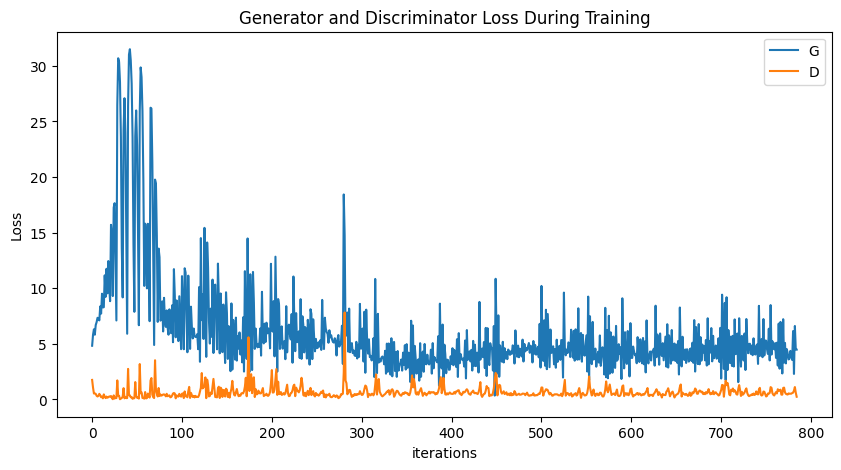

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

G 의 학습과정 시각화

매 에폭마다 fixed_noise를 이용해 생성자가 만들어낸 이미지를 저장한 것을 기억할 거

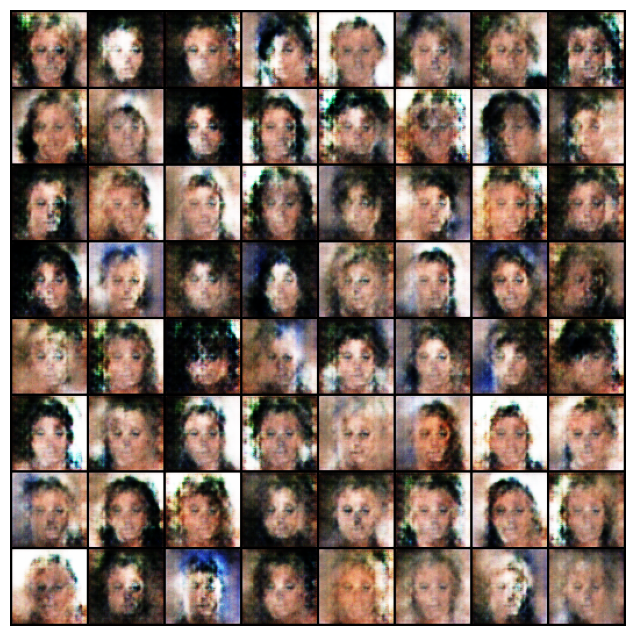

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

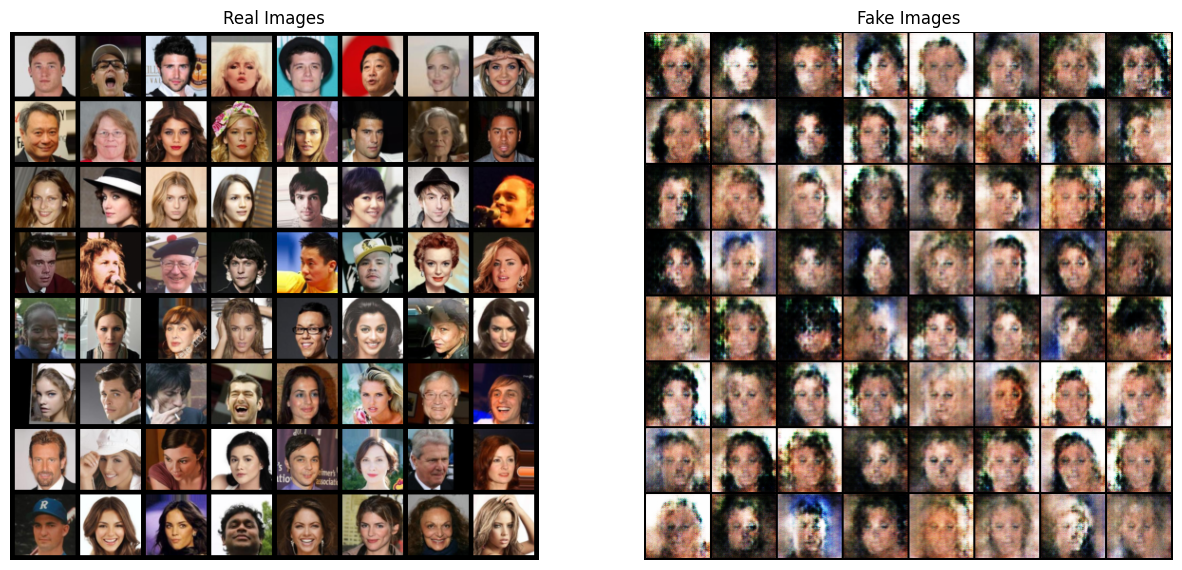

In [ ]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()